# Compare language and age overlap
We ran a query for Spanish/bilingual/English speakers for young/medium/old for all 50 states. Let's see whether young people tend to use more English than old people.

- H_{0}: Young Hispanic ex-pats tend to speak the same amount of English as old Hispanic ex-pats.
- H_{1}: Young Hispanic ex-pats tend to speak more English than old Hispanic ex-pats.

In [4]:
import pandas as pd
from scipy.stats import ttest_ind
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import json

## Load data

In [9]:
query_data = pd.read_csv('../../data/query_results/hispanic_lang_age.tsv', sep='\t', index_col=False)
# convert to json
json_cols = ['geo_locations', 'behavior', 'ages_ranges', 'response']
for c in json_cols:
    print(c)
    query_data.loc[:, c] = query_data.loc[:, c].apply(json.loads)
query_data.head()

geo_locations
behavior
ages_ranges
response


,name,interests,ages_ranges,genders,behavior,scholarities,languages,family_statuses,relationship_statuses,geo_locations,household_composition,all_fields,targeting,response,dau_audience,mau_audience,timestamp,publisher_platforms
0,Hispanic language distributions by age and loc...,NaN,"{u'max': 17, u'min': 13}",0.0,"{u'or': [6003133212372], u'name': u'Hispanic (...",NaN,NaN,NaN,NaN,"{u'country': u'US', u'values': [{u'key': u'384...",NaN,"(('genders', 0), ('ages_ranges', {u'max': 17, ...","{""flexible_spec"": [{""behaviors"": [{""id"": 60031...","{u'data': [{u'estimate_mau': 6900, u'estimate_...",2943,6900,1526987902,"[""facebook""]"
1,Hispanic language distributions by age and loc...,NaN,"{u'max': 17, u'min': 13}",0.0,"{u'or': [6009609054383], u'name': u'Hispanic (...",NaN,NaN,NaN,NaN,"{u'country': u'US', u'values': [{u'key': u'384...",NaN,"(('genders', 0), ('ages_ranges', {u'max': 17, ...","{""flexible_spec"": [{""behaviors"": [{""id"": 60096...","{u'data': [{u'estimate_mau': 1500, u'estimate_...",272,1500,1526987902,"[""facebook""]"
2,Hispanic language distributions by age and loc...,NaN,"{u'max': 17, u'min': 13}",0.0,"{u'or': [6009609033583], u'name': u'Hispanic (...",NaN,NaN,NaN,NaN,"{u'country': u'US', u'values': [{u'key': u'384...",NaN,"(('genders', 0), ('ages_ranges', {u'max': 17, ...","{""flexible_spec"": [{""behaviors"": [{""id"": 60096...","{u'data': [{u'estimate_mau': 4200, u'estimate_...",2015,4200,1526987902,"[""facebook""]"
3,Hispanic language distributions by age and loc...,NaN,"{u'max': 17, u'min': 13}",0.0,"{u'or': [6003133212372], u'name': u'Hispanic (...",NaN,NaN,NaN,NaN,"{u'country': u'US', u'values': [{u'key': u'384...",NaN,"(('genders', 0), ('ages_ranges', {u'max': 17, ...","{""flexible_spec"": [{""behaviors"": [{""id"": 60031...","{u'data': [{u'estimate_mau': 1000, u'estimate_...",498,1000,1526987902,"[""facebook""]"
4,Hispanic language distributions by age and loc...,NaN,"{u'max': 17, u'min': 13}",0.0,"{u'or': [6009609054383], u'name': u'Hispanic (...",NaN,NaN,NaN,NaN,"{u'country': u'US', u'values': [{u'key': u'384...",NaN,"(('genders', 0), ('ages_ranges', {u'max': 17, ...","{""flexible_spec"": [{""behaviors"": [{""id"": 60096...","{u'data': [{u'estimate_mau': 1000, u'estimate_...",0,1000,1526987902,"[""facebook""]"


## Organize data

Extract age range and location first.

In [18]:
# define age
# catch edge case with undefined min
query_data.loc[:, 'ages_ranges'] = query_data.loc[:, 'ages_ranges'].apply(lambda x: {'max' : x['max'], 'min' : 0} if 'min' not in x.keys() else x)
query_data.loc[:, 'age'] = query_data.loc[:, 'ages_ranges'].apply(lambda x: '%d_%d'%(x['min'], x['max']))
query_data.loc[:, 'age'].head()
# define location
state_locs = pd.read_csv('../../data/query_results/state_locs.tsv', sep='\t', index_col=False)
id_state_lookup = dict(zip(state_locs.loc[:, 'key'], state_locs.loc[:, 'name']))
query_data.loc[:, 'state'] = query_data.loc[:, 'geo_locations'].apply(lambda x: id_state_lookup.get(int(x['values'][0]['key'])))
# drop NA state values
query_data = query_data[query_data.loc[:, 'state'].apply(lambda x: type(x) is str)]
query_data.head()

,name,interests,ages_ranges,genders,behavior,scholarities,languages,family_statuses,relationship_statuses,geo_locations,household_composition,all_fields,targeting,response,dau_audience,mau_audience,timestamp,publisher_platforms,age,state
0,Hispanic language distributions by age and loc...,NaN,"{u'max': 17, u'min': 13}",0.0,"{u'or': [6003133212372], u'name': u'Hispanic (...",NaN,NaN,NaN,NaN,"{u'country': u'US', u'values': [{u'key': u'384...",NaN,"(('genders', 0), ('ages_ranges', {u'max': 17, ...","{""flexible_spec"": [{""behaviors"": [{""id"": 60031...","{u'data': [{u'estimate_mau': 6900, u'estimate_...",2943,6900,1526987902,"[""facebook""]",13_17,Alabama
1,Hispanic language distributions by age and loc...,NaN,"{u'max': 17, u'min': 13}",0.0,"{u'or': [6009609054383], u'name': u'Hispanic (...",NaN,NaN,NaN,NaN,"{u'country': u'US', u'values': [{u'key': u'384...",NaN,"(('genders', 0), ('ages_ranges', {u'max': 17, ...","{""flexible_spec"": [{""behaviors"": [{""id"": 60096...","{u'data': [{u'estimate_mau': 1500, u'estimate_...",272,1500,1526987902,"[""facebook""]",13_17,Alabama
2,Hispanic language distributions by age and loc...,NaN,"{u'max': 17, u'min': 13}",0.0,"{u'or': [6009609033583], u'name': u'Hispanic (...",NaN,NaN,NaN,NaN,"{u'country': u'US', u'values': [{u'key': u'384...",NaN,"(('genders', 0), ('ages_ranges', {u'max': 17, ...","{""flexible_spec"": [{""behaviors"": [{""id"": 60096...","{u'data': [{u'estimate_mau': 4200, u'estimate_...",2015,4200,1526987902,"[""facebook""]",13_17,Alabama
3,Hispanic language distributions by age and loc...,NaN,"{u'max': 17, u'min': 13}",0.0,"{u'or': [6003133212372], u'name': u'Hispanic (...",NaN,NaN,NaN,NaN,"{u'country': u'US', u'values': [{u'key': u'384...",NaN,"(('genders', 0), ('ages_ranges', {u'max': 17, ...","{""flexible_spec"": [{""behaviors"": [{""id"": 60031...","{u'data': [{u'estimate_mau': 1000, u'estimate_...",498,1000,1526987902,"[""facebook""]",13_17,Alaska
4,Hispanic language distributions by age and loc...,NaN,"{u'max': 17, u'min': 13}",0.0,"{u'or': [6009609054383], u'name': u'Hispanic (...",NaN,NaN,NaN,NaN,"{u'country': u'US', u'values': [{u'key': u'384...",NaN,"(('genders', 0), ('ages_ranges', {u'max': 17, ...","{""flexible_spec"": [{""behaviors"": [{""id"": 60096...","{u'data': [{u'estimate_mau': 1000, u'estimate_...",0,1000,1526987902,"[""facebook""]",13_17,Alaska


Next, extract the language category.

In [20]:
name_lang_lookup = {
    'Hispanic (US - All)' : 'All',
    'Hispanic (US - Bilingual)' : 'Bilingual',
    'Hispanic (US - Spanish dominant)' : 'Spanish',
}
query_data.loc[:, 'lang'] = query_data.loc[:, 'behavior'].apply(lambda x: name_lang_lookup[x['name']])

0          All
1    Bilingual
2      Spanish
3          All
4    Bilingual
Name: lang, dtype: object

Let's restrict the query to only the relevant stuff to make it easier to handle.

In [33]:
audience_vars = ['dau_audience', 'mau_audience']
query_data_idx = ['state', 'age', 'lang'] + audience_vars
query_data_relevant = query_data.loc[:, query_data_idx]

In [35]:
# also need to add English category
query_data_complete = pd.DataFrame()
lang_var = 'lang'
all_var = 'All'
eng_var = 'English'
for (q_s, q_a), q_data in query_data_relevant.groupby(['state', 'age']):
    q_eng_data = [q_data.loc[:, v].sum() - q_data[q_data.loc[:, lang_var] == all_var].loc[:, v].iloc[0] for v in audience_vars]
    q_eng_data = pd.DataFrame([q_s, q_a, eng_var] + q_eng_data, index=query_data_idx).transpose()
    q_data = q_data.append(q_eng_data)
    q_data = q_data.loc[:, query_data_idx]
    query_data_complete = query_data_complete.append(q_data)

In [36]:
query_data_complete.head()

,state,age,lang,dau_audience,mau_audience
612,Alabama,0_49,All,116354,160000
613,Alabama,0_49,Bilingual,16362,26000
614,Alabama,0_49,Spanish,713,1000
0,Alabama,0_49,English,17075,27000
0,Alabama,13_17,All,2943,6900


Convert counts to percents to compare between ages and locations.

In [55]:
query_data_fixed = pd.DataFrame()
for (q_s, q_a), q_data in query_data_complete.groupby(['state', 'age']):
    q_pct_data = [q_data.loc[:, v] / q_data.loc[:, v].sum() for v in audience_vars]
    q_pct_data = pd.concat(q_pct_data, axis=1)
    q_pct_data.columns = ['%s_pct'%(v) for v in audience_vars]
    q_data = pd.concat([q_data, q_pct_data], axis=1)
    query_data_fixed = query_data_fixed.append(q_data)
query_data_fixed.head()

C:\Users\stewart\AppData\Local\Continuum\miniconda3\envs\assimilation_py27\lib\site-packages\pandas\core\ops.py:686: RuntimeWarning: invalid value encountered in longlong_scalars
  lambda x: op(x, rvalues))


,state,age,lang,dau_audience,mau_audience,dau_audience_pct,mau_audience_pct
612,Alabama,0_49,All,116354,160000,0.773096,0.747664
613,Alabama,0_49,Bilingual,16362,26000,0.108715,0.121495
614,Alabama,0_49,Spanish,713,1000,0.00473742,0.0046729
0,Alabama,0_49,English,17075,27000,0.113452,0.126168
0,Alabama,13_17,All,2943,6900,0.391513,0.377049


## Plot data
Let's get a descriptive idea of the per-state variation across ages and language categories.

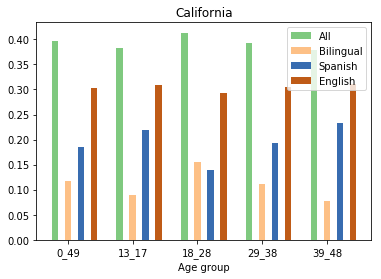

In [88]:
from __future__ import division
import matplotlib.cm as cm
state_i = 'California'
q_i = query_data_fixed[query_data_fixed.loc[:, 'state'] == state_i]
ax = plt.subplot(111)
v_1 = 'age'
v_2 = 'lang'
v_1_vals = q_i.loc[:, v_1].unique()
v_2_vals = q_i.loc[:, v_2].unique()
V_1 = len(v_1_vals)
V_2 = len(v_2_vals)
x = pd.np.arange(V_1)+1
audience_var = 'dau_audience_pct'
x_lab = 'Age group'
x_groups = [[q_i[(q_i.loc[:, v_1] == v_1_val) & 
                 ((q_i.loc[:, v_2] == v_2_val))].loc[:, audience_var].values[0]
             for v_1_val in v_1_vals] 
            for v_2_val in v_2_vals]
bar_offset = 0.2
bar_width = 0.1
cmap = matplotlib.cm.Accent
v_2_colors = cmap(pd.np.arange(V_2) / V_2)
for i, v_2_val in enumerate(v_2_vals):
    c_i = v_2_colors[i]
    ax.bar(x+bar_offset*i, x_groups[i], width=bar_width, color=c_i, label=v_2_val)
ax.legend(loc='upper right')
ax.set_xlabel(x_lab)
# need to center tick location
ax.set_xticks((x + bar_width*(V_1-1)/2))
ax.set_xticklabels(v_1_vals)
ax.set_title(state_i)
plt.show()

In California alone, we see that the main distinction is between 18-28 and the other groups:

- lower Spanish
- higher bilingual

Is this consistent across all states?

In [100]:
def plot_state_data(state, query_data, ax, 
                    v_1 = 'age', v_2 = 'lang', 
                    dv = 'dau_audience', x_lab = 'Age group'):
    """
    Plot data from a given state.
    
    state :: state name
    query_data :: query DataFrame
    ax :: axis for plotting
    iv_1 :: independent variable 1
    iv_2 :: independent variable 2
    dv :: dependent variable
    """
    q_i = query_data[query_data.loc[:, 'state'] == state]
    v_1_vals = q_i.loc[:, v_1].unique()
    v_2_vals = q_i.loc[:, v_2].unique()
    V_1 = len(v_1_vals)
    V_2 = len(v_2_vals)
    x = pd.np.arange(V_1)+1
    ## organize data by independent variables
    x_groups = [[q_i[(q_i.loc[:, v_1] == v_1_val) & 
                     ((q_i.loc[:, v_2] == v_2_val))].loc[:, dv].values[0]
                 for v_1_val in v_1_vals] 
                for v_2_val in v_2_vals]
    bar_offset = 0.2
    bar_width = 0.1
    cmap = matplotlib.cm.Accent
    v_2_colors = cmap(pd.np.arange(V_2) / V_2)
    for i, v_2_val in enumerate(v_2_vals):
        c_i = v_2_colors[i]
        ax.bar(x+bar_offset*i, x_groups[i], width=bar_width, 
               color=c_i, label=v_2_val)
    ax.legend(loc='upper right')
    ax.set_xlabel(x_lab)
    # need to center tick location
    ax.set_xticks((x + bar_width*(V_1-1)/2))
    ax.set_xticklabels(v_1_vals)
    ax.set_title(state)

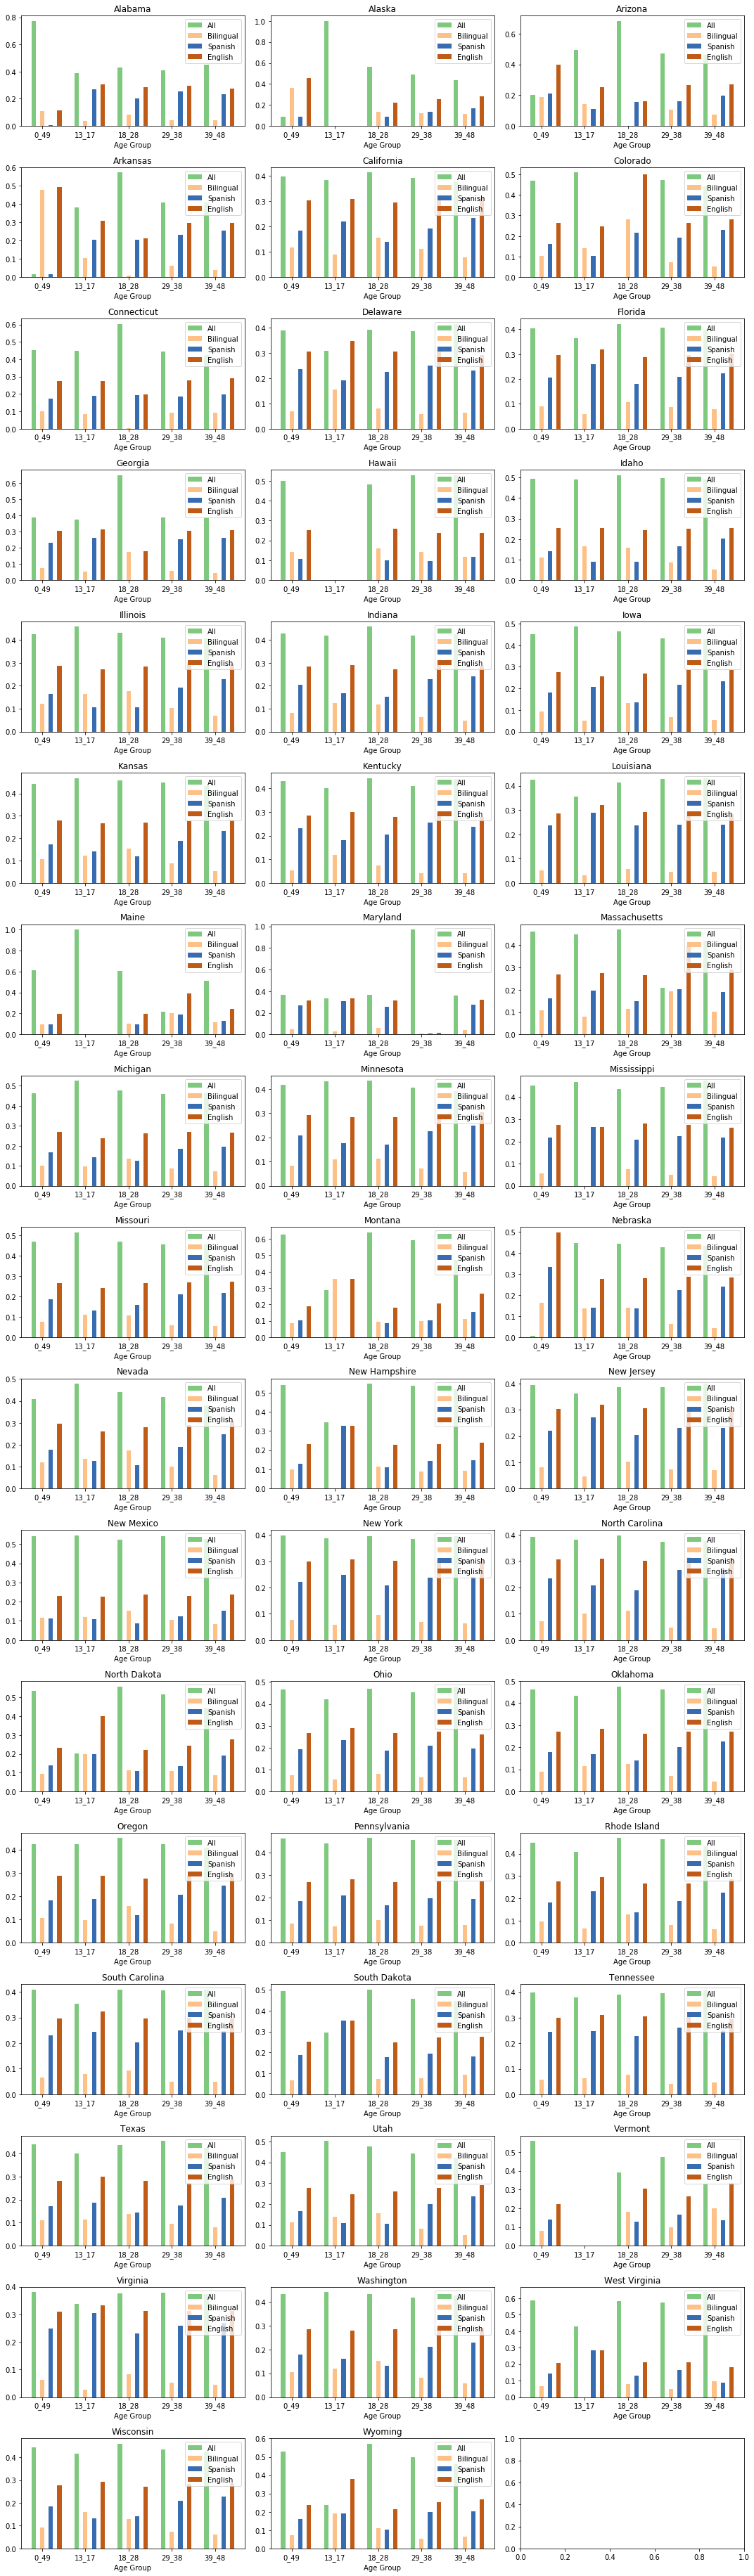

In [105]:
import math
states = query_data_fixed.loc[:, 'state'].unique()
n_states = len(states)
cols = 3
rows = int(math.ceil(n_states / cols))
width = 5
height = 3
fig = plt.figure(figsize=(cols * width, rows * height))
axs = fig.subplots(nrows=rows, ncols=cols)
v_1 = 'age'
v_2 = 'lang'
dv = 'dau_audience_pct'
x_lab = 'Age Group'
for i, s_i in enumerate(states):
    r = int(i / cols)
    c = i % cols
    ax = axs[r, c]
    plot_state_data(s_i, query_data_fixed, ax, 
                    v_1=v_1, v_2=v_2, dv=dv, x_lab=x_lab)
plt.tight_layout()
plt.show()

Across a lot of states we see a similar pattern of younger people tending toward more bilingualism than older people.

Update. We have discovered that this query was issued for all Hispanic people, not just ex-pats.

While we undo that error, let's do significance testing any to determine if there is a difference between age groups. 

In [124]:
from itertools import product
from scipy.stats import ttest_ind
v_1_pairs = list(reduce(lambda x,y: x+y, [[(v_1_vals[i], v_1_vals[j]) for j in range(i+1, V_1)] for i in range(V_1)]))
v_2_val = 'Bilingual'
v_1_samp = query_data_fixed[query_data_fixed.loc[:, v_2] == v_2_val]
v_1_samp.fillna(0, inplace=True)
for v_1_i, v_1_j in v_1_pairs:
    v_1_samp_i = v_1_samp[v_1_samp.loc[:, v_1] == v_1_i].loc[:, dv].values
    v_1_samp_j = v_1_samp[v_1_samp.loc[:, v_1] == v_1_j].loc[:, dv].values
    mean_diff = v_1_samp_i.mean() - v_1_samp_j.mean()
    t, p = ttest_ind(v_1_samp_i, v_1_samp_j)
    print('%s vs. %s: diff = %.3E, t=%.3f, p=%.3E'%(v_1_i, v_1_j, mean_diff, t, p))

0_49 vs. 13_17: diff = 1.520E-02, t=1.095, p=2.764E-01
0_49 vs. 18_28: diff = -9.078E-03, t=-0.743, p=4.596E-01
0_49 vs. 29_38: diff = 2.562E-02, t=2.286, p=2.441E-02
0_49 vs. 39_48: diff = 3.671E-02, t=3.363, p=1.102E-03
13_17 vs. 18_28: diff = -2.427E-02, t=-2.069, p=4.116E-02
13_17 vs. 29_38: diff = 1.042E-02, t=0.977, p=3.309E-01
13_17 vs. 39_48: diff = 2.152E-02, t=2.077, p=4.043E-02
18_28 vs. 29_38: diff = 3.470E-02, t=4.132, p=7.569E-05
18_28 vs. 39_48: diff = 4.579E-02, t=5.719, p=1.161E-07
29_38 vs. 39_48: diff = 1.110E-02, t=1.750, p=8.328E-02


Significant differences ($p < \frac{0.05}{10}=0.005$):

- 0-49 > 39-48
- 18-28 > 39-48
- 18-28 > 39-48

Same thing but with Spanish.

In [125]:
v_2_val = 'Spanish'
v_1_samp = query_data_fixed[query_data_fixed.loc[:, v_2] == v_2_val]
v_1_samp.fillna(0, inplace=True)
for v_1_i, v_1_j in v_1_pairs:
    v_1_samp_i = v_1_samp[v_1_samp.loc[:, v_1] == v_1_i].loc[:, dv].values
    v_1_samp_j = v_1_samp[v_1_samp.loc[:, v_1] == v_1_j].loc[:, dv].values
    mean_diff = v_1_samp_i.mean() - v_1_samp_j.mean()
    t, p = ttest_ind(v_1_samp_i, v_1_samp_j)
    print('%s vs. %s: diff = %.3E, t=%.3f, p=%.3E'%(v_1_i, v_1_j, mean_diff, t, p))

0_49 vs. 13_17: diff = -3.579E-03, t=-0.241, p=8.099E-01
0_49 vs. 18_28: diff = 2.590E-02, t=2.368, p=1.983E-02
0_49 vs. 29_38: diff = -1.854E-02, t=-1.742, p=8.473E-02
0_49 vs. 39_48: diff = -3.516E-02, t=-3.500, p=7.021E-04
13_17 vs. 18_28: diff = 2.947E-02, t=2.053, p=4.271E-02
13_17 vs. 29_38: diff = -1.496E-02, t=-1.058, p=2.926E-01
13_17 vs. 39_48: diff = -3.159E-02, t=-2.307, p=2.316E-02
18_28 vs. 29_38: diff = -4.443E-02, t=-4.465, p=2.147E-05
18_28 vs. 39_48: diff = -6.106E-02, t=-6.557, p=2.584E-09
29_38 vs. 39_48: diff = -1.663E-02, t=-1.854, p=6.672E-02


Significant differences:

- 0-49 < 39-48
- 18-28 < 39-48
- 18-28 < 39-48

**Conclusion:**

- Older Hispanic people ( tend to be more Spanish and less bilingual than the core Facebook base (18-28).

Weaker hypothesis: at least one of the groups has a median different from the others.

testing lang=Spanish
Kruskal-Wallis test: H=36.227, p=2.599E-07
ANOVA one-way: F=7.310, p=1.413E-05


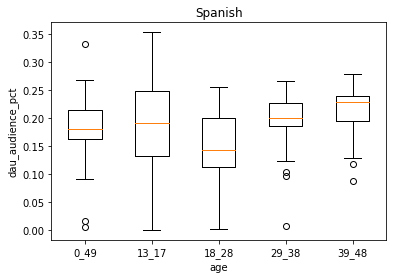

testing lang=Bilingual
Kruskal-Wallis test: H=41.752, p=1.878E-08
ANOVA one-way: F=6.160, p=9.727E-05


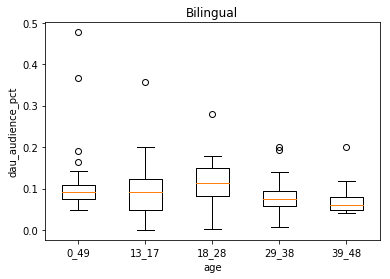

testing lang=English
Kruskal-Wallis test: H=9.544, p=4.884E-02
ANOVA one-way: F=0.684, p=6.035E-01


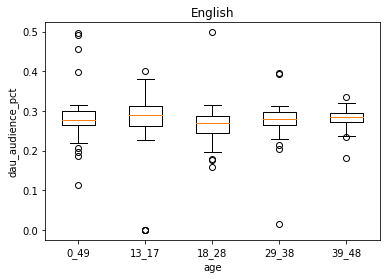

In [154]:
from scipy.stats import kruskal, f_oneway
v_2_vals_test = ['Spanish', 'Bilingual', 'English']
x = pd.np.arange(V_1)+1
for v_2_val in v_2_vals_test:
    v_1_samp = query_data_fixed[query_data_fixed.loc[:, v_2] == v_2_val]
    v_1_samp.fillna(0, inplace=True)
    print('testing %s=%s'%(v_2, v_2_val))
    v_1_vals_test, v_1_groups = zip(*[(d_val, data.loc[:, dv].values) for d_val, data in v_1_samp.groupby(v_1)])
    ## test for median difference
    stat, p = kruskal(*v_1_groups)
    print('Kruskal-Wallis test: H=%.3f, p=%.3E'%(stat, p))
    stat, p = f_oneway(*v_1_groups)
    print('ANOVA one-way: F=%.3f, p=%.3E'%(stat, p))
    ## plot distributions
    plt.boxplot(v_1_groups)
    plt.xticks(x, v_1_vals_test)
    plt.title(v_2_val)
    plt.xlabel(v_1)
    plt.ylabel(dv)
    plt.show()

**Conclusion:**

- There is significant variation among the age groups in terms of Spanish and Bilingual use.